## Importing custom source data

In this example we illustrate how to incorporate a source with a custom spatial dependence in a Tidy3D simulation. We will illustrate this both using data taken from a monitor from another Tidy3D simulation and using a simple array defined from scratch.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web


[16:41:23] WARNING  This version of Tidy3D was pip installed from the         ]8;id=840481;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=760548;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#104\104]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

[16:41:24] INFO     Using client version: 1.9.0rc2                            ]8;id=992376;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=383557;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#122\122]8;;\

### Starting simulation with an in-built source

We will first run a simulation with a [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.GaussianBeam.html) source propagating in empty space. The definition of the source below is for a converging Gaussian beam (negative `waist_distance` parameter).

In [2]:
# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0 / lambda0
fwidth = freq0 / 10

# Simulation size and run time
sim_size = [10, 10, 10]
run_time = 20 / fwidth

# Grid specification
grid_spec = td.GridSpec.auto(wavelength=lambda0)

# In-built GaussianBeam source
pulse = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
waist_radius = 2
src_pos = -4
gaussian_source = td.GaussianBeam(
    source_time=pulse,
    center=(src_pos, 0, 0),
    size=(0, 10, 10),
    waist_radius=waist_radius,
    waist_distance=-8,
    direction="+",
)


We will use monitors to record the fields at the beam waist along the propagation direction, and inject those in another simulation using a [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.CustomFieldSource.html). The best way to achieve this is to use a monitor with a slightly nonzero size in the propagation direction. This is because of the details associated with the Yee grid used in the FDTD algorithm. A monitor with a zero size will interpolate the fields to the exact monitor location along the zero-size dimension, which loses a bit of information related to the numerical grid. On the other hand, a monitor with a small but nonzero size along the propagation direction will store the fields exactly as they are in the simulation. We will illustrate the difference in the results below.

In [3]:
# Monitor for propagation
mnt_xy = td.FieldMonitor(
    center=(0, 0, 0), size=(10, 10, 0), freqs=[freq0], name="field_xy"
)

# Monitors for forward and backward flux
mnt_flux_pos = src_pos - 0.5
mnt_flux_f = td.FluxMonitor(
    center=(-mnt_flux_pos, 0, 0), size=(0, td.inf, td.inf), freqs=[freq0], name="flux_f"
)
mnt_flux_b = td.FluxMonitor(
    center=(mnt_flux_pos, 0, 0), size=(0, td.inf, td.inf), freqs=[freq0], name="flux_b"
)

# Monitor to be used as custom source, 0D along x
mnt_yz_1 = td.FieldMonitor(
    center=(-src_pos, 0, 0), size=(0, 8, 8), freqs=[freq0], name="yz_zero_size_x"
)

# Monitor to be used as custom source, small nonzero along x
mnt_yz_2 = td.FieldMonitor(
    center=(-src_pos, 0, 0), size=(1e-5, 8, 8), freqs=[freq0], name="yz_nonzero_size_x"
)


<AxesSubplot: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

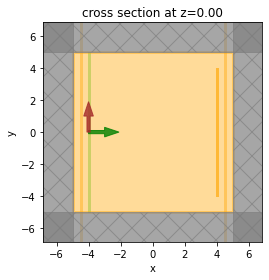

In [4]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    sources=[gaussian_source],
    monitors=[mnt_xy, mnt_flux_f, mnt_flux_b, mnt_yz_1, mnt_yz_2],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)
sim.plot(z=0)


In [5]:
sim_data = web.run(sim, task_name="free space gaussian")


           INFO     Using Tidy3D credentials from stored file.                     ]8;id=3506;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=942881;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#77\77]8;;\

[16:41:25] INFO     Authentication successful.                                     ]8;id=413141;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=31545;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#37\37]8;;\

           INFO     Created task 'free space gaussian' with task_id             ]8;id=27754;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=164644;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '9f4e08d0-1b47-4ad6-b566-b72022ca0df0'.                                  

Output()

[16:41:26] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=288576;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=12440;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                             ]8;id=513490;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=185023;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:41:30] INFO     status = preprocess                                         ]8;id=488918;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=252658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:41:33] INFO     starting up solver                                          ]8;id=415956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=897069;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:41:37] INFO     running solver                                              ]8;id=938608;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981219;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:41:40] INFO     early shutoff detected, exiting.                            ]8;id=80340;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=895035;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                        ]8;id=677334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=52244;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[16:41:43] INFO     status = success                                            ]8;id=519474;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=39498;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=113474;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14209;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=505717;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=202045;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:41:44] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=25568;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=110670;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

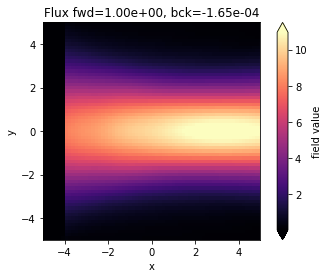

In [6]:
fig, ax = plt.subplots(1)
sim_data.plot_field("field_xy", field_name="Ey", val="abs", ax=ax)
ax.set_xlim([-sim.size[0] / 2, sim.size[0] / 2])
ax.set_ylim([-sim.size[1] / 2, sim.size[1] / 2])
ax.set_title(
    f"Flux fwd={float(sim_data['flux_f'].flux):1.2e}, bck={float(sim_data['flux_b'].flux):1.2e}"
)
plt.show()


### Custom source from simulation data

Now we can use the recorded data as an input to a [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.CustomFieldSource.html) in another simulation. We will run two simulations to illustrate the difference between zero and nonzero size of the monitor along `x`. Note that we can create the source directly using the [FieldData](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.FieldData.html) method `to_source`. Note that we can center the source anywhere we want. The size of the source is by default taken from the [FieldData](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.FieldData.html) used to create it. However, the source size needs to be `0` along one of the directions, so in the case of the `nonzero_size_x` data, we have to manually reset it.

In [7]:
custom_src_1 = sim_data["yz_zero_size_x"].to_source(source_time=pulse, center=(0, 0, 0))
custom_src_2 = sim_data["yz_nonzero_size_x"].to_source(
    source_time=pulse,
    center=(0, 0, 0),
    size=(
        0,
        8,
        8,
    ),  # by default taken from the data, but it must be reset to zero along x
)
sim_1 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    sources=[custom_src_1],
    monitors=[mnt_xy, mnt_flux_f, mnt_flux_b],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)
sim_2 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    sources=[custom_src_2],
    monitors=[mnt_xy, mnt_flux_f, mnt_flux_b],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


In [8]:
batch = web.Batch(simulations={"zero_x": sim_1, "nonzero_x": sim_2})
batch_results = batch.run(path_dir="data")


[16:41:45] INFO     Created task 'zero_x' with task_id                          ]8;id=704788;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=996573;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'd0f0ff30-7817-4999-8810-23d014f55dcd'.                                  

Output()

Output()

[16:41:46] INFO     Created task 'nonzero_x' with task_id                       ]8;id=441633;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=85167;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '7e5d171b-d1f2-4a59-885c-433760532b6f'.                                  

Output()

Output()

[16:41:48] Started working on Batch.                                         ]8;id=674502;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=931288;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#361\361]8;;\

Output()

[16:42:03] Batch complete.                                                   ]8;id=492677;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=636366;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#382\382]8;;\

Below we plot the injected field in the two simulations. As can be seen, there is a bit of backwards ppower injected in the simulation in which we used a `FieldMonitor` with size `0` along x, while the injection is extremely clean in the case where the size of the monitor was slightly larger than zero. As mentioned above, this is because the fields from the original simulation are captured exactly as they are on the numerical grid.

[16:42:04] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=601243;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=562474;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "data/d0f0ff30-7817-4999-8810-23d014f55dcd.hdf5"                         

Output()

           INFO     loading SimulationData from                                 ]8;id=809443;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=500982;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\
                    data/d0f0ff30-7817-4999-8810-23d014f55dcd.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=964212;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=350251;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "data/7e5d171b-d1f2-4a59-885c-433760532b6f.hdf5"                         

Output()

[16:42:05] INFO     loading SimulationData from                                 ]8;id=133992;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=318836;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\
                    data/7e5d171b-d1f2-4a59-885c-433760532b6f.hdf5                           

Text(0.5, 1.0, 'Flux: fwd=1.00e+00, bck=-1.89e-06\nnonzero-size FieldData along x')

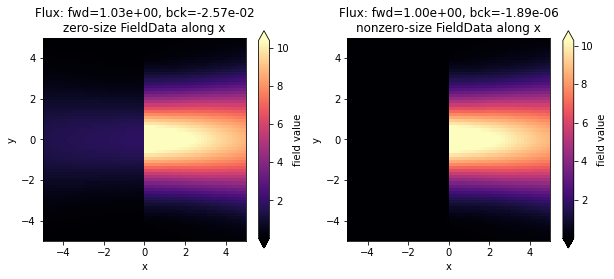

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data = batch_results["zero_x"]
sim_data.plot_field("field_xy", field_name="Ey", val="abs", ax=ax[0])
ax[0].set_xlim([-sim.size[0] / 2, sim.size[0] / 2])
ax[0].set_ylim([-sim.size[1] / 2, sim.size[1] / 2])
title = f"Flux: fwd={float(sim_data['flux_f'].flux):1.2e}, bck={float(sim_data['flux_b'].flux):1.2e}"
title += "\nzero-size FieldData along x"
ax[0].set_title(title)
sim_data = batch_results["nonzero_x"]
sim_data.plot_field("field_xy", field_name="Ey", val="abs", ax=ax[1])
ax[1].set_xlim([-sim.size[0] / 2, sim.size[0] / 2])
ax[1].set_ylim([-sim.size[1] / 2, sim.size[1] / 2])
title = f"Flux: fwd={float(sim_data['flux_f'].flux):1.2e}, bck={float(sim_data['flux_b'].flux):1.2e}"
title += "\nnonzero-size FieldData along x"
ax[1].set_title(title)


### Importing arbitrary fields

Next we show how to import arbitrary fields. We create numpy arrays to emulate the same Gaussian beam input. Data can be imported from file in exactly the same way, once it is read into a numpy array. We create two types of datasets: the first one contains the `Ey` field only, while the second one contains `Ey` and `Hz`. We can provide any combination of field components to the custom source, as long as at least one of the tangential fields is defined. However, as we will see, providing both `E` and `H` is required to make the source directional.

In [10]:
# Scalar gaussian field with the same waist_radius as the beam source above
ys, zs = np.linspace(-4, 4, 101), np.linspace(-4, 4, 101)
y_grid, z_grid = np.meshgrid(ys, zs)
scalar_gaussian = np.exp(-(y_grid**2 + z_grid**2) / waist_radius**2)

# Field dataset defining only the E-field
dataset_E = td.FieldDataset(
    Ey=td.ScalarFieldDataArray(
        scalar_gaussian[None, ..., None],
        coords={
            "x": [0],
            "y": ys,
            "z": zs,
            "f": [freq0],
        },
    )
)

# Field dataset defining both E and H
dataset_EH = td.FieldDataset(
    Ey=td.ScalarFieldDataArray(
        scalar_gaussian[None, ..., None],
        coords={
            "x": [0],
            "y": ys,
            "z": zs,
            "f": [freq0],
        },
    ),
    Hz=td.ScalarFieldDataArray(
        scalar_gaussian[None, ..., None] / td.ETA_0,
        coords={
            "x": [0],
            "y": ys,
            "z": zs,
            "f": [freq0],
        },
    ),
)

custom_src_3 = td.CustomFieldSource(
    source_time=pulse,
    center=(0, 0, 0),
    size=(0, 8, 8),
    field_dataset=dataset_E,
)
custom_src_4 = td.CustomFieldSource(
    source_time=pulse,
    center=(0, 0, 0),
    size=(0, 8, 8),
    field_dataset=dataset_EH,
)
sim_3 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    sources=[custom_src_3],
    monitors=[mnt_xy, mnt_flux_f, mnt_flux_b],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)
sim_4 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    sources=[custom_src_4],
    monitors=[mnt_xy, mnt_flux_f, mnt_flux_b],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


In [11]:
batch = web.Batch(simulations={"custom_E": sim_3, "custom_EH": sim_4})
batch_results = batch.run(path_dir="data")


           INFO     Created task 'custom_E' with task_id                        ]8;id=515021;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=497349;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'ccdb7f6e-f081-42ef-a1a0-f2e4b65f72a8'.                                  

Output()

Output()

[16:42:06] INFO     Created task 'custom_EH' with task_id                       ]8;id=304062;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=495344;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'daca04ba-ba98-4278-abf8-2d6d9b13df42'.                                  

Output()

Output()

[16:42:08] Started working on Batch.                                         ]8;id=813559;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=234153;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#361\361]8;;\

Output()

[16:42:23] Batch complete.                                                   ]8;id=702801;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=936273;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#382\382]8;;\

As can be seen below, if we only provide the `E` field to the custom source (or only the `H` field), the source is not directional, but instead equal power is injected in both directions. We can make it directional by providing both fields, provided that they are set with the correct phase offset. In this example, multiplying one of the two fields by `-1` will make the source inject in the backwards direction.

Note also that in the case of custom fields, the flux is not automatically normalized. This could however be done by hand if both the `E` and the `H` fields are known, for example using the Tidy3D [FieldData](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.FieldData.html) property `flux`.

[16:42:24] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=505470;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=626290;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "data/ccdb7f6e-f081-42ef-a1a0-f2e4b65f72a8.hdf5"                         

Output()

           INFO     loading SimulationData from                                 ]8;id=501955;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434703;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\
                    data/ccdb7f6e-f081-42ef-a1a0-f2e4b65f72a8.hdf5                           

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=833103;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=277585;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "data/daca04ba-ba98-4278-abf8-2d6d9b13df42.hdf5"                         

Output()

[16:42:25] INFO     loading SimulationData from                                 ]8;id=417837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=106808;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\
                    data/daca04ba-ba98-4278-abf8-2d6d9b13df42.hdf5                           

Text(0.5, 1.0, 'Flux: fwd=8.53e-03, bck=-2.10e-04\nE and H fields supplied')

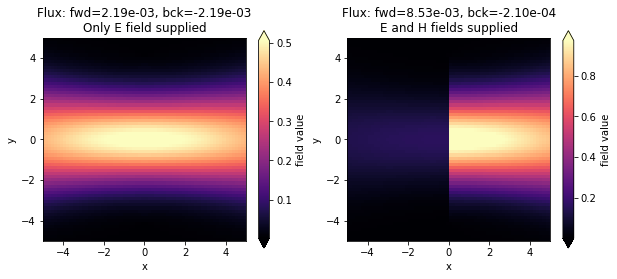

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data = batch_results["custom_E"]
sim_data.plot_field("field_xy", field_name="Ey", val="abs", ax=ax[0])
ax[0].set_xlim([-sim.size[0] / 2, sim.size[0] / 2])
ax[0].set_ylim([-sim.size[1] / 2, sim.size[1] / 2])
title = f"Flux: fwd={float(sim_data['flux_f'].flux):1.2e}, bck={float(sim_data['flux_b'].flux):1.2e}"
title += "\nOnly E field supplied"
ax[0].set_title(title)
sim_data = batch_results["custom_EH"]
sim_data.plot_field("field_xy", field_name="Ey", val="abs", ax=ax[1])
ax[1].set_xlim([-sim.size[0] / 2, sim.size[0] / 2])
ax[1].set_ylim([-sim.size[1] / 2, sim.size[1] / 2])
title = f"Flux: fwd={float(sim_data['flux_f'].flux):1.2e}, bck={float(sim_data['flux_b'].flux):1.2e}"
title += "\nE and H fields supplied"
ax[1].set_title(title)


### Final notes

- Only the field components tangential to the custom source plane are needed and used in the simulation. Due to the equivalence principle, these fully define the currents that need to be injected. This is not to say that the normal components of the data (`Ex`, `Hx` in our example) is lost or not injected. It is merely not needed as it can be uniquely obtained using the tangential components.
- Source data can be imported from file just as shown here, after the data is imported as a numpy array using standard numpy functions like [loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).
- If the data is not coming from a Tidy3D simulation, the normalization is likely going to be arbitrary and the directionality of the source will likely not be perfect, even if both the `E` and `H` fields are provided. An empty normalizing run may be needed to accurately normalize results.